In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor, Pool
from google.cloud import storage
import os
from io import StringIO, BytesIO
from itertools import islice


In [2]:
def load_test_sets():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_test = bucket.get_blob('data/train_test_sets/test_02032024.csv')
    blob_test_processed = bucket.get_blob('data/train_test_sets/processed_test_set_DROP_UNPRACTICAL.csv.csv')
    test_bytes = blob_test.download_as_bytes()
    test_processed_bytes = blob_test_processed.download_as_bytes()
    test = pd.read_csv(BytesIO(test_bytes), index_col=0)
    processed_test = pd.read_csv(BytesIO(test_processed_bytes), index_col=0)
    return test, processed_test

In [85]:
def load_results():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob = bucket.get_blob('data/results/results_drop_low_importance.csv')
    res_bytes = blob.download_as_bytes()
    results = pd.read_csv(BytesIO(res_bytes), index_col=0)
    return results

In [3]:
def load_model(name):
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_cb = bucket.get_blob(f'models/{name}.cbm')
    cb_name = f"{name}.cbm"
    blob_cb.download_to_filename(cb_name)
    cb = CatBoostRegressor().load_model(cb_name)
    return cb

In [10]:
def get_set_for_prediction(df):
    df = df.copy()
    X, y = df.drop(columns=['raw_price']), df['raw_price']
    categorical_features = [X.columns.get_loc(x) for x in
                          X.select_dtypes(include=['object', 'category', 'int', 'bool']).columns.tolist()]
    X.iloc[:,categorical_features] = X.iloc[:,categorical_features].fillna("nan").copy()
    pool = Pool(data=X, label=y, cat_features=categorical_features)
    return pool

In [6]:
test, test_procesed = load_test_sets()
cb2 = load_model('catboost_q2')
cb1 = load_model('catboost_q1')
cb3 = load_model('catboost_q3')

In [11]:
test_pool = get_set_for_prediction(test_procesed)

In [44]:
test['pred_q1'] = cb1.predict(test_pool)
test['pred_q2'] = cb2.predict(test_pool)
test['pred_q3'] = cb3.predict(test_pool)

In [45]:
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q2'].shape[0]/test.shape[0]

0.008232278418613822

In [46]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q2'].shape[0]/test.shape[0]

0.09647047224686976

In [47]:
test['brand_count'] = test.groupby('brand')['raw_price'].transform('count')
test['brand_model_count'] = test.groupby(['brand','model'])['raw_price'].transform('count')
test['brand_model_year_count'] = test.groupby(['brand','model','registration_year'])['raw_price'].transform('count')

<Axes: ylabel='Frequency'>

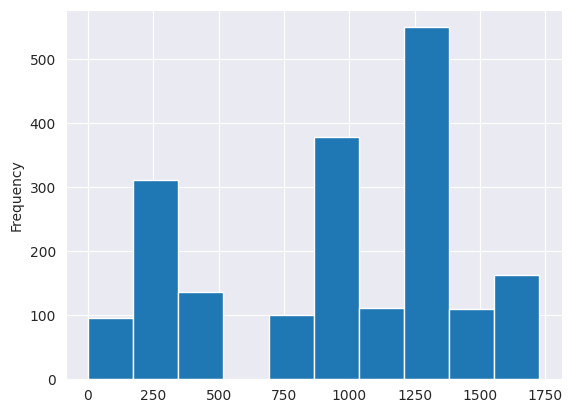

In [28]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_count.plot(kind='hist')

<Axes: ylabel='Frequency'>

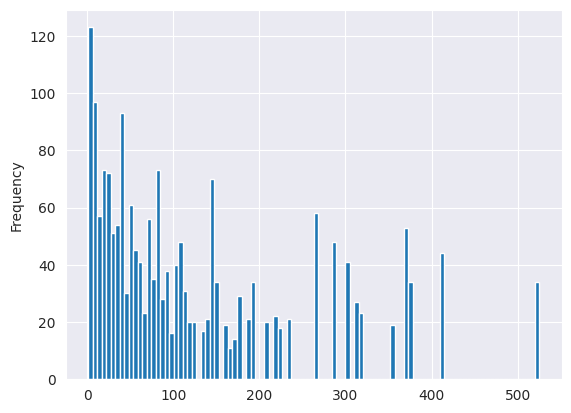

In [34]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_model_count.plot(kind='hist',bins=100)

<Axes: ylabel='Frequency'>

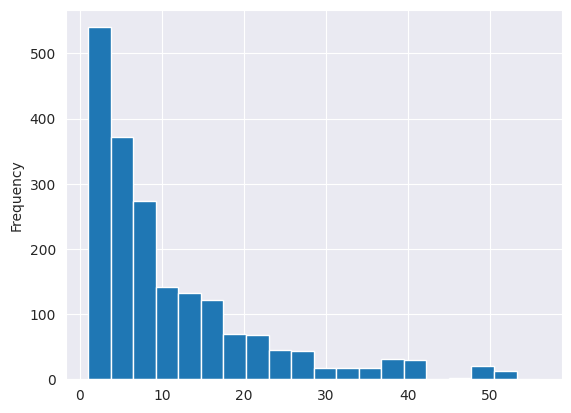

In [37]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_model_year_count.plot(kind='hist',bins=20)

In [35]:
# We see that anomalies in the q1,q2,q3 preds occur for sparse car brand and models in the data

In [48]:
test['pred_q1_old'] = test.pred_q1
test['pred_q3_old'] = test.pred_q3

In [49]:
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1'] = test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3_old']
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3'] = test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1_old']
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q2'] = (test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1'] + test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3'])/2

test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q2'] = (test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q1'] + test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q3'])/2


In [50]:
test['uncertainty'] = (test.pred_q3 - test.pred_q1)/test.pred_q2

In [83]:
qs = [0.01,0.05,0.25,0.5,0.75,0.9,0.95,0.99]

In [84]:
test.uncertainty.describe(qs)

count    20286.000000
mean         0.187194
std          0.167349
min          0.000024
1%           0.013110
5%           0.041784
25%          0.098493
50%          0.151203
75%          0.234060
90%          0.341853
95%          0.433167
99%          0.691459
max          9.807750
Name: uncertainty, dtype: float64

(0.0, 1.0)

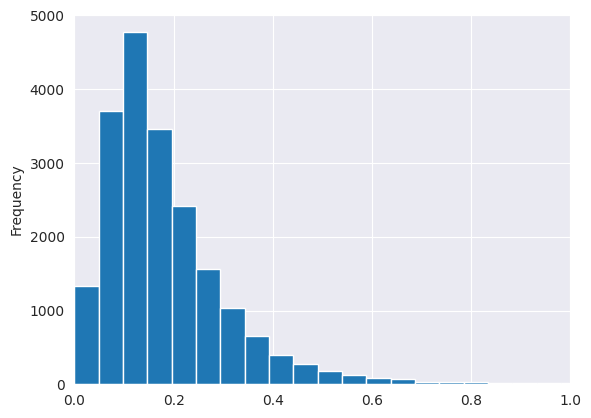

In [57]:
test.uncertainty.plot(kind='hist', bins=200)
plt.xlim([0,1])

(0.0, 1.0)

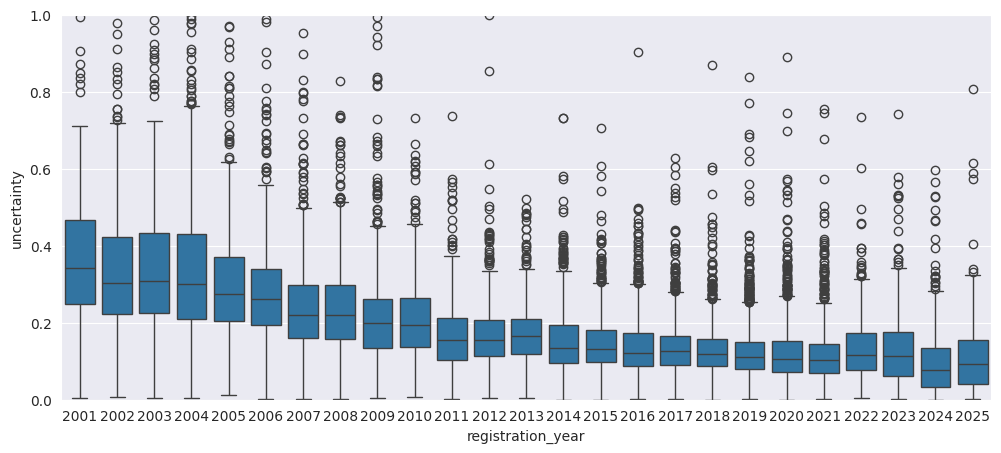

In [63]:
plt.figure(figsize=(12,5))
sns.boxplot(x=test.registration_year, y=test.uncertainty)
plt.ylim([0,1])



(0.0, 200000.0)

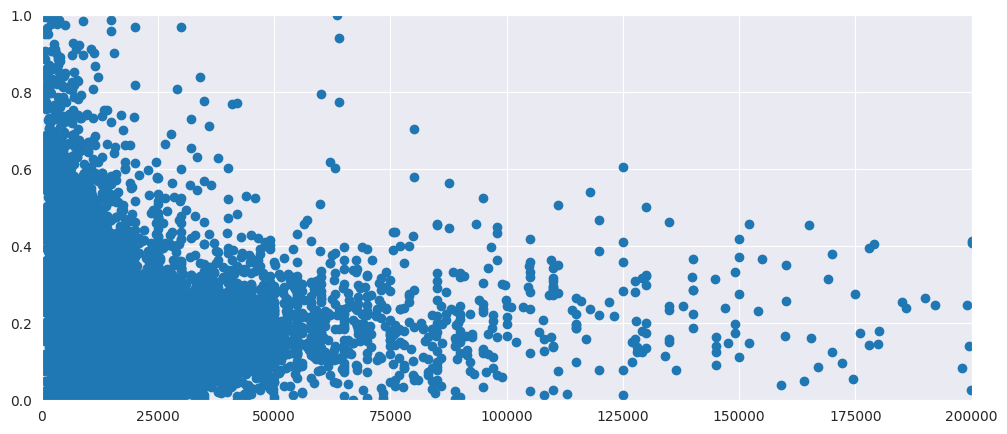

In [65]:
plt.figure(figsize=(12,5))
plt.scatter(test.raw_price, test.uncertainty)
plt.ylim([0,1])
plt.xlim([0,200000])

(0.0, 500000.0)

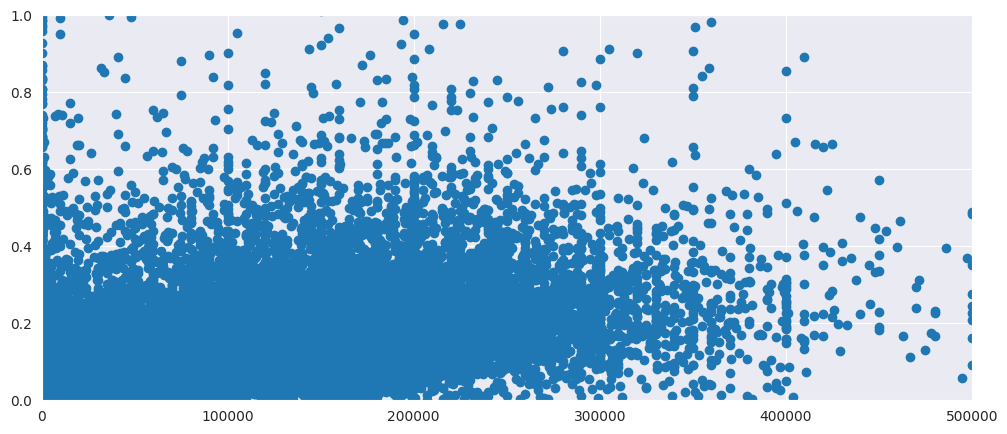

In [66]:
plt.figure(figsize=(12,5))
plt.scatter(test.mileage, test.uncertainty)
plt.ylim([0,1])
plt.xlim([0,500000])

(0.0, 1.0)

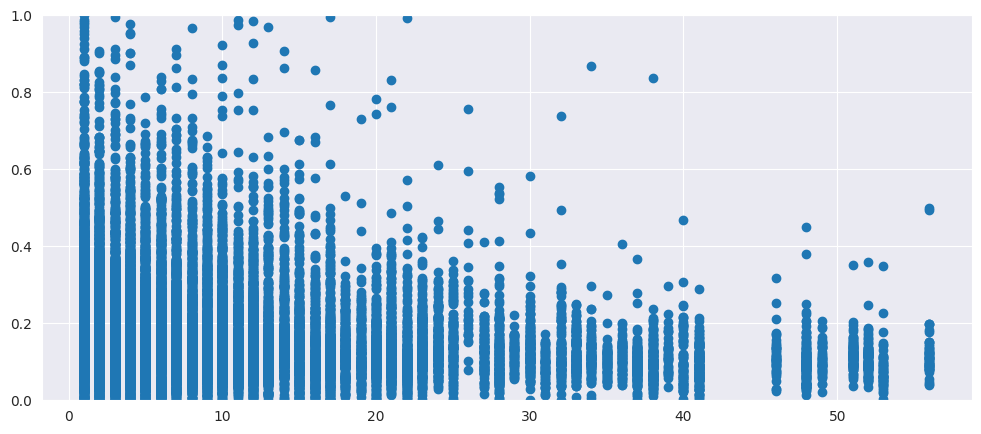

In [69]:
plt.figure(figsize=(12,5))
plt.scatter(test.brand_model_year_count, test.uncertainty)
plt.ylim([0,1])

In [86]:
results = load_results()

In [87]:
results.columns

Index(['id', 'residuals_drop_low_importance',
       'abs_residuals_drop_low_importance', 'ape_drop_low_importance'],
      dtype='object')

In [88]:
test['ape'] = results.ape_drop_low_importance

(0.0, 1.0)

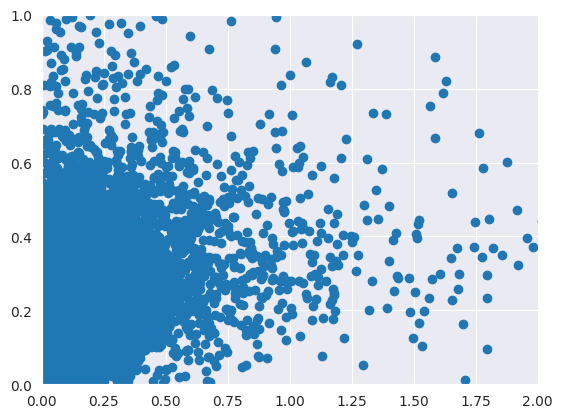

In [92]:
plt.scatter(test.ape, test.uncertainty)
plt.xlim([0,2])
plt.ylim([0,1])

In [98]:
mean_reliability = np.mean(test.uncertainty)

In [104]:
def reliability_score(uncertainty,central_uncertainty,lamda):
    return 1 - 1/(1 + np.exp(-lamda*(uncertainty - central_uncertainty )))

([<matplotlib.axis.YTick at 0x7780b676bb50>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

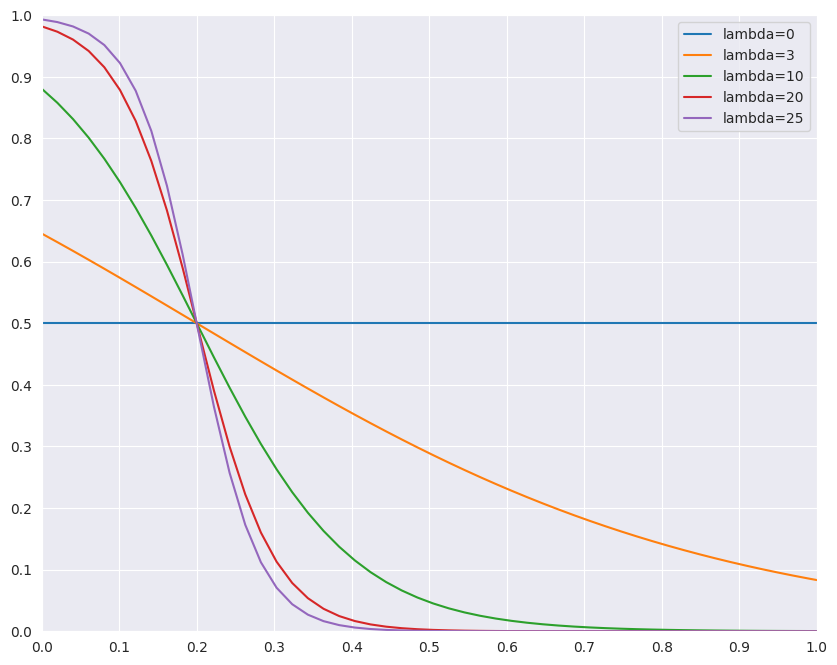

In [111]:
xs = np.linspace(0,2,100)
lamdas = [0,3,10, 20, 25]
plt.figure(figsize=(10,8))
for i in lamdas:
    plt.plot(xs, reliability_score(xs, 0.2, i), label=f"lambda={str(i)}")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,1])
plt.xticks(np.linspace(0, 1, 11))  # 20 ticks on x-axis
plt.yticks(np.linspace(0, 1, 11))

In [113]:
print(reliability_score(0.05, 0.2, 20))
print(reliability_score(0.15, 0.2, 20))

0.9525741268224333
0.731058578630005


In [114]:
test['final_uncertainty'] = test.uncertainty.apply(lambda x : reliability_score(x, 0.2,20))

<Axes: xlabel='brand'>

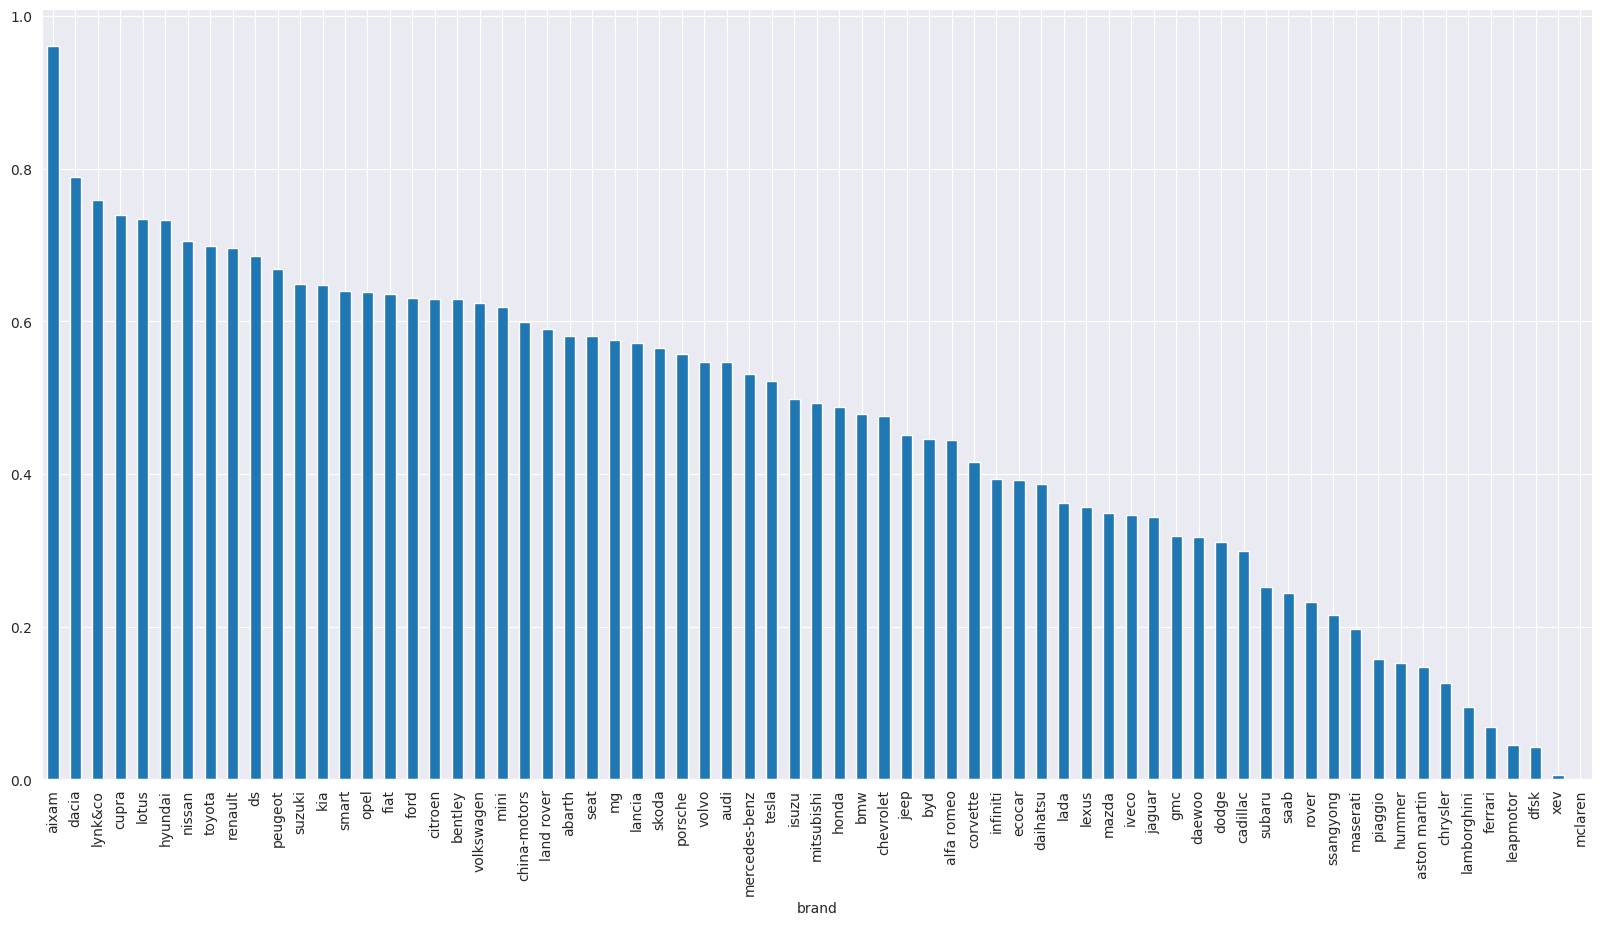

In [117]:
plt.figure(figsize=(20,10))
test.groupby('brand')['final_uncertainty'].agg('mean').sort_values(ascending=False).plot(kind='bar')
